In [1]:
!nvidia-smi

Fri May  4 14:25:23 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 45%   75C    P2   112W / 250W |   6150MiB / 11172MiB |     26%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:42:00.0 Off |                  N/A |
| 46%   71C    P2    64W / 250W |   2538MiB / 11172MiB |     20%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
%matplotlib inline

BATCH_SIZE=1
GPUS=['/gpu:1']
GPU_CORES=len(GPUS)
MODEL_NAME="FACE_DETECTOR_RETRAIN_410_SMALL_LR_CLASSBALANCED_STOPGRADIENT"

In [3]:
import time
import sys
class ProcessBar():
    def reset(self, length):
        self._length = length
        self._start = time.time()
    def show(self, i, msg=""):
        percents = (i + 1) / self._length
        equal_length = int(50 * percents) * "="
        empty_length = (49 - int(50 * percents)) * " "
        elapsed_time = time.time() - self._start
        eta_time = elapsed_time / percents * (1 - percents)
        line_str = "[{}>{}] {}/{} {:.1f}% {:.2f}s ETA:{:.2f}s {}"\
            .format(equal_length, empty_length, i, self._length,
                    100 * percents, eta_time, elapsed_time, msg)
        sys.stdout.write("\r" + line_str)
    def summary(self, i, msg=""):
        line_str = "[{}] {} {} {:.2f}s {}".format(50 * "=", i, self._length, time.time() - self._start, msg)
        sys.stdout.write("\r{}\n".format(line_str))
pb = ProcessBar()

In [4]:
gts = {}
X=[]
line_count = 0
with open("data/wider_face_split/wider_face_train_bbx_gt.txt", "r") as f:
    file_name = f.readline().replace('\n', '')
    while file_name is not '':
        count_str = f.readline()
        count = int(count_str)
        gts[file_name] = []
        for i in range(count):
            args = f.readline().replace('\n','').split(' ')
            x1,y1,w,h=int(args[0]),int(args[1]),int(args[2]),int(args[3])
            if w<12 or h<12:
                continue
            gts[file_name].append([x1,y1,w,h])
        if len(gts[file_name]) != 0:            
            X.append(file_name)
        file_name = f.readline().replace('\n', '')

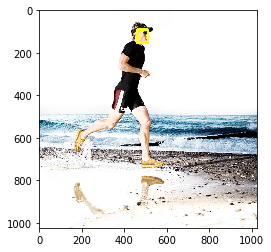

In [5]:
def get_path(img_name):
    return "data/WIDER_train/images/" + img_name
img_name = X[np.random.randint(len(X))]
img = cv2.imread(get_path(img_name))
for gt in gts[img_name]:
    x1, y1, w, h = gt
    cv2.rectangle(img, (x1, y1), (x1+w, y1+h), (0, 255, 255), 12)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [6]:
RESIZE_S=1120
BATCH_ANCHORS=128
ANCHORS_MUL=32
# k = 9
boxes = []
bases = [16,32,48,64,96,128,256,512]
for base in bases:
    boxes.append((base,base))
print(boxes)
def mapping(src):
    src=np.ceil(src/2)
    src=np.ceil(src/2-1)
    for i in range(3):
        src=np.ceil(src/2)
    return int(src)
def compute_iou(bound1, bound2):
    xa = max(bound1[0], bound2[0])
    ya = max(bound1[1], bound2[1])
    xb = min(bound1[0]+bound1[2], bound2[0]+bound2[2])
    yb = min(bound1[1]+bound1[3], bound2[1]+bound2[3])
    if xa>xb or ya>yb:
        return 0
    interact = (xb-xa)*(yb-ya)
    union = (bound2[2]*bound2[3])+(bound1[2]*bound1[3])-interact
    return interact/union
def generating_anchors(img, gts):
    height, width = mapping(img.shape[0]),mapping(img.shape[1])
    anchors_cls = np.zeros([height, width, len(boxes)*1])
    anchors_reg = np.zeros([height, width, len(boxes)*4])
    anchors_mas = np.zeros([height, width, len(boxes)])
    anchors_bas = np.zeros([height, width, len(boxes), 4])
    gts_dict=[]
    for ind,gt in enumerate(gts):
        gts_dict.append((0,0,0,0))
    for ih in range(height):
        for iw in range(width):
            for ind,box in enumerate(boxes):
                x1,y1,w,h=iw*ANCHORS_MUL-box[0]//2,ih*ANCHORS_MUL-box[1]//2,box[0],box[1]
                anchors_bas[ih, iw, ind] = np.array([y1, x1, y1 + h, x1 + w])
                if x1<0 or y1<0 or x1+w>img.shape[1] or y1+h>img.shape[0]:
                    continue
                max_iou = 0
                max_index = 0
                for index,gt in enumerate(gts):
                    iou=compute_iou((x1,y1,w,h),gt)
                    if iou>gts_dict[index][3]:
                        gts_dict[index]=ih,iw,ind,iou
                    if iou>max_iou:
                        max_iou=iou
                        max_index=index
                if max_iou > 0.7:
                    anchors_cls[ih,iw,ind]=1
                    gt=gts[max_index]
                    anchors_reg[ih,iw,ind*4]=(gt[0]-x1)/w
                    anchors_reg[ih,iw,ind*4+1]=(gt[1]-y1)/h
                    anchors_reg[ih,iw,ind*4+2]=np.log(gt[2]/w)
                    anchors_reg[ih,iw,ind*4+3]=np.log(gt[3]/h)
                    anchors_mas[ih,iw,ind]=1
                elif max_iou < 0.3:
                    anchors_cls[ih,iw,ind]=0
                    anchors_mas[ih,iw,ind]=1
    for index in range(len(gts_dict)):
        gt=gts[index]
        ih,iw,ind,_=gts_dict[index]
        box=boxes[ind]
        x1,y1,w,h=iw*ANCHORS_MUL-box[0]//2,ih*ANCHORS_MUL-box[1]//2,box[0],box[1]
        anchors_cls[ih,iw,ind]=1
        anchors_reg[ih,iw,ind*4]=(gt[0]-x1)/w
        anchors_reg[ih,iw,ind*4+1]=(gt[1]-y1)/h
        anchors_reg[ih,iw,ind*4+2]=np.log(gt[2]/w)
        anchors_reg[ih,iw,ind*4+3]=np.log(gt[3]/h)
        anchors_mas[ih,iw,ind]=1
    height=img.shape[0]
    width=img.shape[1]
    anchors_bas=anchors_bas/np.array([height-1,width-1,height-1,width-1])
    anchors_cls=anchors_cls.reshape(-1,len(boxes))
    anchors_reg=anchors_reg.reshape(-1,len(boxes),4)
    anchors_mas=anchors_mas.reshape(-1,len(boxes))
    anchors_bas=anchors_bas.reshape(-1,len(boxes),4)
    true_pos=np.where((anchors_cls==1)&(anchors_mas==1))
    if true_pos[0].shape[0]>BATCH_ANCHORS//2:
        rand_choice=np.random.choice(true_pos[0].shape[0],true_pos[0].shape[0]-BATCH_ANCHORS//2,replace=False)
        anchors_mas[true_pos[0][rand_choice],true_pos[1][rand_choice]]=0
        true_pos=np.where((anchors_cls==1)&(anchors_mas==1))
    false_pos=np.where((anchors_cls==0)&(anchors_mas==1))
    rand_choice=np.random.choice(len(false_pos[0]),len(false_pos[0])-(BATCH_ANCHORS-len(true_pos[0])),replace=False)
    anchors_mas[false_pos[0][rand_choice],false_pos[1][rand_choice]]=0 
    return anchors_cls,anchors_reg,anchors_mas,anchors_bas
def reg_to_bound(reg,img,anchor_ind,ind):
    h,w,c=img.shape
    w_per_h=mapping(w)
    ih=anchor_ind//w_per_h
    iw=anchor_ind-ih*w_per_h
    box=boxes[ind]
    x1,y1=iw*ANCHORS_MUL-box[0]//2,ih*ANCHORS_MUL-box[1]//2
    w=np.exp(reg[2])*box[0]
    h=np.exp(reg[3])*box[1]
    x=box[0]*reg[0]+x1
    y=box[1]*reg[1]+y1
    x,y,w,h=int(x),int(y),int(w),int(h)
    return x,y,w,h

[(16, 16), (32, 32), (48, 48), (64, 64), (96, 96), (128, 128), (256, 256), (512, 512)]


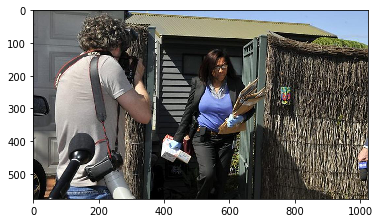

In [7]:
file_name = X[np.random.randint(len(X))]
while len(gts[file_name]) != 1:
    file_name = X[np.random.randint(len(X))]
full_name = get_path(file_name)
img = cv2.imread(full_name)
plt.imshow(cv2.cvtColor(cv2.imread(full_name), cv2.COLOR_BGR2RGB))
cls,reg,mask,base=generating_anchors(img,gts[file_name])

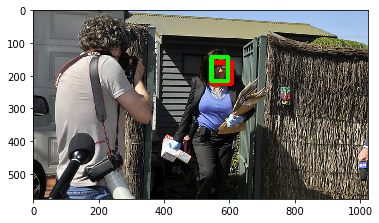

In [8]:
height, width = mapping(img.shape[0]),mapping(img.shape[1])
reshape_cls = cls.reshape(height, width, len(boxes))
ih = np.where(reshape_cls == 1)[0][0]
iw = np.where(reshape_cls == 1)[1][0]
b_ind = np.where(reshape_cls == 1)[2][0]
rect = (ih * 32 - boxes[b_ind][0] // 2, iw * 32 - boxes[b_ind][1] // 2, *boxes[b_ind])
gt = gts[file_name][0]
cp_img = np.copy(img)
cp_img = cv2.cvtColor(cp_img, cv2.COLOR_BGR2RGB)
cp_img = cv2.rectangle(cp_img, (rect[1], rect[0]), (rect[1] + rect[2], rect[0] + rect[3]), (255, 0, 0), 12)
cp_img = cv2.rectangle(cp_img, (gt[0], gt[1]), (gt[0] + gt[2], gt[1] + gt[3]), (0, 255, 0), 12)
plt.imshow(cp_img)

In [9]:
import tensorflow as tf
def create_epoch_input(name):
    input=tf.placeholder(tf.float32,name='{}_input'.format(name))
    op=tf.summary.scalar(name,input)
    return input,op
class TensorBoardLogger:
    def __init__(self,sess,names,path):
        self._sess=sess
        self._feed={}
        self._values={}
        with tf.name_scope('train'):
            for name in names:
                self._feed['train_{}'.format(name)]=create_epoch_input(name)
        with tf.name_scope('epoch'):
            for name in names:
                self._feed['epoch_{}'.format(name)]=create_epoch_input(name)
                self._values['epoch_{}'.format(name)]=0.
        with tf.name_scope('valid'):
            for name in names:
                self._feed['valid_{}'.format(name)]=create_epoch_input(name)
                self._values['valid_{}'.format(name)]=0.
        self._file_summary=tf.summary.FileWriter(path,sess.graph)
    def log(self,params,step):
        ops=[]
        feed_dict={}
        for name in params.keys():
            input,op=self._feed['train_'+name]
            summary=self._sess.run(op,feed_dict={input:params[name]})
            self._file_summary.add_summary(summary,step)
    def update(self,params,mode):
        for name in params.keys():
            self._values['{}_{}'.format(mode,name)]+=params[name]
    def summary(self,mode,steps,epoch):
        return_dict={}
        for key in self._values.keys():
            if key.startswith(mode):
                input,op=self._feed[key]
                if self._values[key] == 0.0:
                    continue
                value=self._values[key]/steps
                return_dict[key.replace(mode+'_','')]=value
                self._values[key]=0.
                summary=self._sess.run(op,feed_dict={input:value})
                self._file_summary.add_summary(summary,epoch)
        return return_dict

In [10]:
# data augumentation function.
import cv2
def gauss_random(mean = 1.0, var = 1):
    sigma = var ** 0.5
    return np.random.normal(mean, sigma)
def adjust_gamma(image, gamma=0.8):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)
def add_salt_pepper_noise(X_img):
    X_img_copy = X_img.copy()
    row, col, _ = X_img_copy.shape
    salt_vs_pepper = 0.2
    amount = 0.004
    num_salt = np.ceil(amount * X_img_copy.size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_img_copy.size * (1.0 - salt_vs_pepper))
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_img_copy.shape]
    X_img_copy[coords[0], coords[1], coords[2]] = 1
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_img_copy.shape]
    X_img_copy[coords[0], coords[1], coords[2]] = 0
    return X_img_copy
def add_gaussian_noise(X_img, mean = 0, var=0.1, all_channel = False):
    gaussian_noise_imgs = []
    row, col, channel = X_img.shape
    sigma = var ** 0.5
    if all_channel is False:
        gaussian = np.random.normal(mean, sigma, (row, col, 1)).astype(np.float32)
        gaussian = np.clip(gaussian, 0, 1)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
    else:
        gaussian = np.random.normal(mean, sigma, (row, col, channel)).astype(np.float32)
        gaussian = np.clip(gaussian, 0, 1)
    gaussian_img = cv2.addWeighted(X_img.astype(np.float32) / 255.0, 0.75, 0.25 * gaussian, 0.25, 0)
    return np.asarray(gaussian_img * 255.0, dtype=np.uint8)
def random_crop(img, target=(512, 512)):
    row, col, _ = img.shape
    random_offset_X = np.random.randint(row - target[0])
    random_offset_Y = np.random.randint(col - target[1])
    return img[random_offset_X: random_offset_X + target[0],
               random_offset_Y: random_offset_Y + target[1]]
# alpha => contract, beta => brightness
def change_contract_brightness(image, alpha=1, beta=0):
    image = image.astype(np.float32)
    return np.clip(alpha * image + beta, 0, 255).astype(np.uint8)
class dataFlow:
    def __init__(self,X,augumentation=True):
        self._X=X
        self._augumentation=augumentation
    def __getitem__(self,ids):
        batches=[]
        for i in range(len(ids)):
            while True:
                img_name=self._X[np.random.randint(len(self._X))]
                img=cv2.imread(get_path(img_name))
                if img.shape[0] < 2048 and img.shape[1] < 2048:
                    break
            # resize_factor = min(img.shape[0], img.shape[1]) / 600
            # img = cv2.resize(img, dsize=(0,0), fx=1/resize_factor, fy=1/resize_factor)
            if self._augumentation:
                if np.random.rand() < 0.2:
                    rand_gamma = gauss_random(var=0.03)
                    img = adjust_gamma(img, rand_gamma)
                if np.random.rand() < 0.2:
                    img = add_gaussian_noise(img)
                if np.random.rand() < 0.2:
                    img = add_salt_pepper_noise(img)
                if np.random.rand() < 0.2:
                    random_contract = gauss_random(var=0.01)
                    img = change_contract_brightness(img, alpha=random_contract)
                if np.random.rand() < 0.2:
                    random_brightness = gauss_random(mean=0, var=0.01)
                    img = change_contract_brightness(img, beta=random_brightness)
            cls,reg,mask,base=generating_anchors(img,gts[img_name])
            gt = np.asarray(gts[img_name])
            gt = np.array([gt[:, 1], gt[:, 0], gt[:, 1] + gt[:, 3], gt[:, 0] + gt[:, 2]]).T
            batches.append((img,reg,cls,mask,gt,base,img_name))
        return batches
    def __len__(self):
        return len(self._X)

In [11]:
from sklearn.model_selection import train_test_split
import tflearn
X_train,X_valid=train_test_split(X,test_size=0.1,random_state=44)
train_set=dataFlow(X_train)
valid_set=dataFlow(X_valid, augumentation=False)
def get_flow(data_flow,shuffle = True,order=False,threads=16,max_queue=32):
    coord = tf.train.Coordinator()
    flow = tflearn.data_flow.FeedDictFlow({
        "data": data_flow
    },  coord, 
        batch_size=BATCH_SIZE,
        shuffle=shuffle, 
        continuous=True, num_threads=threads, max_queue=max_queue,
        ensure_data_order=order)
    return flow
train_flow = get_flow(train_set)
valid_flow = get_flow(valid_set)
train_flow.start()
valid_flow.start()

# ROI Pooling

In [12]:
import tensorflow as tf
import cv2
import numpy as np

In [13]:
def nms_topk(propsal_bboxes, propsal_scores, iou_threshold=0.7):
    with tf.variable_scope('nms_proposal'):
        selected_indics = tf.image.non_max_suppression(propsal_bboxes, propsal_scores, 300, iou_threshold=iou_threshold)
        selected_bboxes = tf.gather(propsal_bboxes, selected_indics)
        selected_scores = tf.gather(propsal_scores, selected_indics)
        return selected_bboxes, selected_scores
def nms(propsal_bboxes, propsal_scores, iou_threshold=0.3):
    with tf.variable_scope('nms_roi'):
        selected_indics = tf.image.non_max_suppression(propsal_bboxes, propsal_scores, 300, iou_threshold=iou_threshold)
        selected_bboxes = tf.gather(propsal_bboxes, selected_indics)
        selected_scores = tf.gather(propsal_scores, selected_indics)
        return selected_bboxes, selected_scores
def compute_overlap(boxes1, boxes2, image):
    b1 = tf.reshape(tf.tile(tf.expand_dims(boxes1, 1),
                            [1, 1, tf.shape(boxes2)[0]]), [-1, 4])
    b2 = tf.tile(boxes2, [tf.shape(boxes1)[0], 1])
    height = tf.cast(tf.shape(image)[1], dtype=tf.float32)
    width = tf.cast(tf.shape(image)[2], dtype=tf.float32)
    b1 = b1 * tf.concat([[height - 1], [width - 1], [height - 1], [width - 1]], axis=0)
    b1_y1, b1_x1, b1_y2, b1_x2 = tf.split(b1, 4, axis=1)
    b2_y1, b2_x1, b2_y2, b2_x2 = tf.split(b2, 4, axis=1)
    y1 = tf.maximum(b1_y1, b2_y1)
    x1 = tf.maximum(b1_x1, b2_x1)
    y2 = tf.minimum(b1_y2, b2_y2)
    x2 = tf.minimum(b1_x2, b2_x2)
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)
    b1_area = (b1_y2 - b1_y1) * (b1_x2 - b1_x1)
    b2_area = (b2_y2 - b2_y1) * (b2_x2 - b2_x1)
    union = b1_area + b2_area - intersection
    iou = intersection / union
    overlaps = tf.reshape(iou, [tf.shape(boxes1)[0], tf.shape(boxes2)[0]])
    return overlaps
def delta(box, gt_box, image):
    box = tf.cast(box, dtype=tf.float32)
    gt_box = tf.cast(gt_box, dtype=tf.float32)
    height = tf.cast(tf.shape(image)[1], dtype=tf.float32)
    width = tf.cast(tf.shape(image)[2], dtype=tf.float32)
    box = box * tf.concat([[height - 1], [width - 1], [height - 1], [width - 1]], axis=0)
    height = box[:, 2] - box[:, 0]
    width = box[:, 3] - box[:, 1]
    center_y = box[:, 0] + 0.5 * height
    center_x = box[:, 1] + 0.5 * width
    gt_height = gt_box[:, 2] - gt_box[:, 0]
    gt_width = gt_box[:, 3] - gt_box[:, 1]
    gt_center_y = gt_box[:, 0] + 0.5 * gt_height
    gt_center_x = gt_box[:, 1] + 0.5 * gt_width
    dy = (gt_center_y - center_y) / height
    dx = (gt_center_x - center_x) / width
    dh = tf.log(gt_height / height)
    dw = tf.log(gt_width / width)
    result = tf.stack([dy, dx, dh, dw], axis=1)
    return result
def roi_negtive_postive(overlaps, boxes, gt_boxes, image):
    postives_indices = tf.cast(tf.where(overlaps > 0.3), dtype=tf.int32)
    postives = tf.ones(tf.shape(postives_indices)[:1])
    postives = tf.scatter_nd(postives_indices, postives, tf.shape(overlaps))
    postives_sum = tf.reduce_sum(postives, axis=1)
    postives_indices = tf.cast(tf.where(tf.equal(postives_sum, 1)), dtype=tf.int32)
    postives_overlap = tf.gather_nd(overlaps, postives_indices)
    postives_gts_indics = tf.argmax(postives_overlap, axis=1)
    roi_postive_proposals = tf.gather_nd(boxes, postives_indices)
    roi_gt_boxes = tf.gather(gt_boxes, postives_gts_indics)
    deltas = delta(roi_postive_proposals, roi_gt_boxes, image)
    postives = tf.ones(tf.shape(postives_indices)[:1])
    postives = tf.scatter_nd(postives_indices, postives, tf.shape(overlaps)[:1])
    targets = tf.scatter_nd(postives_indices, deltas, tf.concat([tf.shape(overlaps)[:1], [4]], axis=0))
    postives = tf.reshape(postives, [tf.shape(overlaps)[0], 1])
    return postives, targets
# logits: [batch_size,H,W,len(boxes)].
# labels: same as logits.
# indics: three dimension list.
def rpn_log_loss_graph(logits,labels,masks,name):
    with tf.name_scope(name):
        pos_count = tf.reduce_sum(labels)
        neg_count = tf.reduce_sum(masks) - pos_count
        pos_weight = neg_count / pos_count
        losses = tf.nn.weighted_cross_entropy_with_logits(labels, logits, pos_weight=pos_weight)
        print(losses.shape, masks.shape)
        losses = losses * masks
        return tf.reduce_sum(losses) / (1e-7 + tf.reduce_sum(masks))
# smooth l1 loss
# smooth(x)=0.5*x^2 if |x| < 1
# smooth(x)=|x|-0.5 otherwise
def smooth_l1_loss(y_true,y_pred):
    diff=tf.abs(y_true-y_pred)
    less_than_one=tf.cast(tf.contrib.keras.backend.less(diff,1.0),"float32")
    loss=(less_than_one*0.5*diff**2)+(1-less_than_one)*(diff-0.5)
    return loss
def rpn_l2_loss_graph(reg_bounds,bboxes,labels,masks,name):
    with tf.name_scope(name):
        losses = smooth_l1_loss(bboxes,reg_bounds)
        losses = tf.reshape(losses, [-1, len(boxes), 4])
        masks = tf.reshape(masks, [-1, len(boxes), 1])
        masks = tf.contrib.keras.backend.repeat_elements(masks, 4, 2)
        labels = tf.reshape(labels, [-1, len(boxes), 1])
        labels = tf.contrib.keras.backend.repeat_elements(labels, 4, 2)
        print(masks.shape, losses.shape)
        losses = losses * masks
        losses = losses * labels
        return 10 * tf.reduce_sum(losses) / (1e-7 + tf.reduce_sum(labels))
def roi_l2_loss_graph(reg_bounds, bboxes, labels, name):
    with tf.name_scope(name):
        losses = smooth_l1_loss(bboxes,reg_bounds)
        losses = tf.reshape(losses, [-1, 4])
        labels = tf.reshape(labels, [-1, 1])
        labels = tf.contrib.keras.backend.repeat_elements(labels, 4, 1)
        losses = losses * labels
        return 10 * tf.reduce_sum(losses) / (1e-7 + tf.reduce_sum(labels))
def roi_log_loss_graph(logits, labels, name):
    with tf.name_scope(name):
        losses = tf.losses.sigmoid_cross_entropy(labels,logits)
        return 10 * losses
def average_gradients(tower_grads):
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        grads = []
        for g, _ in grad_and_vars:
            expanded_g = tf.expand_dims(g, 0)
            grads.append(expanded_g)
        grad = tf.concat(axis=0, values=grads)
        grad = tf.reduce_mean(grad, 0)
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads
def make_rpn_graph(resnet_output):
    shared_net=tf.layers.conv2d(resnet_output,256,3,padding='same',activation=tf.nn.relu,name='shared_features')
    class_logits=tf.layers.conv2d(shared_net,len(boxes),1,padding='same',activation=None,name='rpn_logits')
    class_logits=tf.reshape(class_logits,[-1,len(boxes)])
    reg_bounds=tf.layers.conv2d(shared_net,len(boxes)*4,1,padding='same',activation=None,name='rpn_regression')
    reg_bounds=tf.reshape(reg_bounds,[-1,len(boxes),4])
    return class_logits,reg_bounds
def roi_pooling(input_features, crops, box_ind, is_training):
    with tf.variable_scope('roi'):
        crop_features = tf.image.crop_and_resize(input_features, crops, box_ind, (7, 7))
        net = tf.layers.conv2d(crop_features, 1024, (7, 7), padding='valid', activation=None, name='conv1')
        net = tf.layers.batch_normalization(net, training=is_training, name='bn1')
        net = tf.nn.relu(net, name='relu1')
        net = tf.layers.conv2d(net, 1024, (1, 1), activation=None, name='conv2')
        net = tf.layers.batch_normalization(net, training=is_training, name='bn2')
        net = tf.nn.relu(net, name='relu2')
        shared = tf.reshape(net, [-1, 1024])
        roi_class_logits = tf.layers.dense(shared, 1, activation=None, name='logits_dense')
        roi_class_probs = tf.nn.sigmoid(roi_class_logits, name='probs')
        roi_bbox = tf.layers.dense(shared, 4, activation=None, name='bbox')
        return roi_class_logits, roi_class_probs, roi_bbox
def delta_2_box(deltas, boxes):
    deltas = tf.reshape(deltas, [-1, 4])
    boxes = tf.reshape(boxes, [-1, 4])
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    gt_center_y = deltas[:, 0] * height + center_y
    gt_center_x = deltas[:, 1] * width + center_x
    gt_height = tf.exp(deltas[:, 2]) * height
    gt_width = tf.exp(deltas[:, 3]) * width
    y1 = tf.maximum(gt_center_y - gt_height / 2, 0)
    x1 = tf.maximum(gt_center_x - gt_width / 2, 0)
    y2 = tf.minimum(y1 + gt_height, 1)
    x2 = tf.minimum(x1 + gt_width, 1)
    return tf.stack([y1, x1, y2, x2], axis=1)
def delta_2_box_rpn(deltas, boxes):
    deltas = tf.reshape(deltas, [-1, 4])
    boxes = tf.reshape(boxes, [-1, 4])
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    gt_center_x = deltas[:, 0] * width + center_x
    gt_center_y = deltas[:, 1] * height + center_y
    gt_width = tf.exp(deltas[:, 2]) * width
    gt_height = tf.exp(deltas[:, 3]) * height
    y1 = tf.maximum(gt_center_y - gt_height / 2, 0)
    x1 = tf.maximum(gt_center_x - gt_width / 2, 0)
    y2 = tf.minimum(y1 + gt_height, 1)
    x2 = tf.minimum(x1 + gt_width, 1)
    return tf.stack([y1, x1, y2, x2], axis=1)

# load pretraind resnet model from keras.application.

In [14]:
# with tf.variable_scope('resnet50'):
#     resnet=tf.contrib.keras.applications.ResNet50(include_top=False)
# saver = tf.train.Saver()
# sess = tf.contrib.keras.backend.get_session()
# saver.save(sess, 'models/resnet50/imagenet_only')

In [15]:
tf.contrib.keras.backend.clear_session()
tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default(), tf.device('/cpu:0'):
    inputs,p_rpn_probs,p_rpn_bounds=[],[],[]
    p_roi_probs, p_roi_bboxes = [], []
    learning_rate=tf.placeholder(tf.float32,name='learning_rate')
    rpn_step_tensor = tf.Variable(0, trainable=False, name='rpn_step')
    roi_step_tensor = tf.Variable(0, trainable=False, name='roi_step')
    is_training = tf.contrib.keras.backend.learning_phase()
    rpn_optimizer=tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9,name='rpn_optimizer')
    roi_optimizer=tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9,name='roi_optimizer')
    p_rpn_log_loss, p_rpn_l2_loss, p_rpn_acc = [], [], []
    p_roi_log_loss, p_roi_l2_loss, p_roi_acc = [], [], []
    tower_rpn_grads = []
    tower_roi_grads = []
    with tf.variable_scope(tf.get_variable_scope()) as vscope:
        for index, gpu_name in enumerate(GPUS):
            print("INIT TOWER_{}".format(index))
            with tf.name_scope('tower_{}'.format(index)), tf.device(gpu_name):
                images=tf.placeholder(dtype=tf.float32, shape=[None,None,3], name='input_image_{}'.format(index))
                reshape_images=tf.reshape(images, tf.concat([[1], tf.shape(images)], axis=0))
                bboxes=tf.placeholder(dtype=tf.float32, shape=[None,len(boxes),4], name='input_boxes_{}'.format(index))
                labels=tf.placeholder(dtype=tf.float32, shape=[None,len(boxes)], name='input_label_{}'.format(index))
                masks=tf.placeholder(dtype=tf.float32, shape=[None,len(boxes)], name='input_masks_{}'.format(index))
                ground_truths_input = tf.placeholder(dtype=tf.float32, shape=[None, 4],
                                                     name='input_ground_truths_{}'.format(index))
                anchor_base = tf.placeholder(dtype=tf.float32, shape=[None, len(boxes), 4])
                inputs.append((images, bboxes, labels, masks, ground_truths_input, anchor_base))
                with tf.variable_scope('resnet50'):
                    resnet=tf.contrib.keras.applications.ResNet50(include_top=False,weights=None,input_tensor=reshape_images)
                    resnet_output=resnet.get_layer('activation_{}'.format(index*49+49)).output
                with tf.variable_scope('rpn'):
                    rpn_logits,rpn_bounds=make_rpn_graph(resnet_output)
                    rpn_probs = tf.nn.sigmoid(rpn_logits, name='rpn_probs')
                    p_rpn_probs,p_rpn_bounds=p_rpn_probs+[rpn_probs],p_rpn_bounds+[rpn_bounds]
                    proposal_regions_input = delta_2_box_rpn(rpn_bounds, anchor_base)
                    proposal_logits_input = tf.reshape(rpn_logits, [-1])
                with tf.variable_scope('rpn_loss'):
                    rpn_log_loss = rpn_log_loss_graph(rpn_logits,labels,masks,name='rpn_log_loss')
                    rpn_l2_loss = rpn_l2_loss_graph(rpn_bounds,bboxes,labels,masks,name='rpn_l2_loss')
                    error_case = tf.cast(tf.not_equal(tf.multiply(tf.round(rpn_probs), masks), labels), 'float32')
                    rpn_accuracy = 1 - tf.reduce_sum(error_case) / tf.reduce_sum(masks)
                    p_rpn_log_loss, p_rpn_l2_loss = p_rpn_log_loss+[rpn_log_loss],p_rpn_l2_loss+[rpn_l2_loss]
                    p_rpn_acc += [rpn_accuracy]
                    rpn_loss = rpn_log_loss + rpn_l2_loss
                with tf.variable_scope('roi'):
                    regions_after_nms, logits_after_nms = nms_topk(proposal_regions_input, proposal_logits_input)
                    overlaps = compute_overlap(regions_after_nms, ground_truths_input, reshape_images)
                    roi_target_logits, roi_target_bbox = roi_negtive_postive(overlaps, regions_after_nms,
                                                                             ground_truths_input, reshape_images)
                    boxes_index = tf.zeros(tf.shape(regions_after_nms)[:1], dtype=tf.int32)
                    # boxes_index = tf.stop_gradient(boxes_index)
                    # regions_after_nms = tf.stop_gradient(regions_after_nms)
                    roi_class_logits, roi_class_prob, roi_bbox = \
                        roi_pooling(resnet_output, regions_after_nms, boxes_index, is_training)
                    roi_box_real = delta_2_box(roi_bbox, regions_after_nms)
                    roi_bboxes_after_nms, roi_probs_after_nms = nms(roi_box_real, tf.reshape(roi_class_prob, [-1]), 0.3)
                    p_roi_probs, p_roi_bboxes = p_roi_probs + [roi_probs_after_nms], p_roi_bboxes + [roi_bboxes_after_nms]
                with tf.variable_scope('roi_loss'):
                    roi_l2_loss = roi_l2_loss_graph(roi_bbox, roi_target_bbox, roi_target_logits, 'roi_l2_loss')
                    roi_log_loss = roi_log_loss_graph(roi_class_logits, roi_target_logits, 'roi_log_loss')
                    error_case = tf.cast(tf.not_equal(tf.round(roi_class_prob), roi_target_logits), 'float32')
                    roi_accuracy = 1 - tf.reduce_sum(error_case) / tf.cast(tf.shape(roi_target_logits)[0], 'float32')
                    p_roi_log_loss, p_roi_l2_loss = p_roi_log_loss + [roi_log_loss], p_roi_l2_loss + [roi_l2_loss]
                    p_roi_acc += [roi_accuracy]
                    roi_loss = roi_log_loss + roi_l2_loss
                total_loss = roi_loss + rpn_loss
                tf.get_variable_scope().reuse_variables()
                rpn_trainable = [v for v in tf.trainable_variables() if not v.name.startswith('roi')]
                rpn_grads = rpn_optimizer.compute_gradients(rpn_loss, var_list=rpn_trainable)
                roi_grads = roi_optimizer.compute_gradients(total_loss)
                tower_rpn_grads.append(rpn_grads)
                tower_roi_grads.append(roi_grads)
    m_rpn_log_loss = tf.reduce_mean(p_rpn_log_loss, name='rpn_log_loss')
    m_rpn_l2_loss = tf.reduce_mean(p_rpn_l2_loss, name='rpn_l2_loss')
    m_rpn_acc = tf.reduce_mean(p_rpn_acc, name='rpn_acc')
    m_roi_log_loss = tf.reduce_mean(p_roi_log_loss, name='roi_log_loss')
    m_roi_l2_loss = tf.reduce_mean(p_roi_l2_loss, name='roi_l2_loss')
    m_roi_acc = tf.reduce_mean(p_roi_acc, name='roi_acc')
    rpn_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.variable_scope('rpn_train'):
        rpn_grads = average_gradients(tower_rpn_grads)        
        with tf.control_dependencies(rpn_update_ops):
            global_step = rpn_step_tensor
            train_rpn_op = rpn_optimizer.apply_gradients(rpn_grads, global_step)
    roi_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.variable_scope('roi_train'):
        roi_grads = average_gradients(tower_roi_grads)
        with tf.control_dependencies(roi_update_ops):
            global_step = roi_step_tensor
            train_roi_op = roi_optimizer.apply_gradients(roi_grads, global_step)
with graph.as_default():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    resnet50_varaiables=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='resnet50')
    saver=tf.train.Saver(resnet50_varaiables)
    saver.restore(sess,"models/resnet50/imagenet_only")
    tf.train.global_step(sess, rpn_step_tensor)
    tf.train.global_step(sess, roi_step_tensor)
    LOGGER=TensorBoardLogger(sess,
                             ['rpn_loss', 'rpn_cls', 'rpn_reg', 'rpn_acc',
                              'roi_loss', 'roi_reg', 'roi_cls', 'roi_acc'],
                             'logs/{}'.format(MODEL_NAME))

INIT TOWER_0
(?, 8) (?, 8)
(?, 8, 4) (?, 8, 4)
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from models/resnet50/imagenet_only


In [16]:
ops_in_train_rpn = [train_rpn_op, m_rpn_log_loss, m_rpn_l2_loss, m_rpn_acc, rpn_step_tensor]
ops_in_valid_rpn = [m_rpn_log_loss, m_rpn_l2_loss, m_rpn_acc]
ops_in_train_roi = [train_roi_op, m_rpn_log_loss, m_rpn_l2_loss, m_rpn_acc,\
                    m_roi_log_loss, m_roi_l2_loss, m_roi_acc, roi_step_tensor]
ops_in_valid_roi = [m_rpn_log_loss, m_rpn_l2_loss, m_rpn_acc, m_roi_log_loss, m_roi_l2_loss, m_roi_acc]

In [17]:
def build_feed_dict_end2end(inputs, values):
    feed_dict={}
    for i in range(GPU_CORES):
        feed_dict[inputs[i][0]]=values[i][0]
        feed_dict[inputs[i][1]]=values[i][1]
        feed_dict[inputs[i][2]]=values[i][2]
        feed_dict[inputs[i][3]]=values[i][3]
        feed_dict[inputs[i][4]]=values[i][4]
        feed_dict[inputs[i][5]]=values[i][5]
    return feed_dict

In [62]:
LR = 1e-4
RESTORE_EPOCH = 32
DECAY_EPOCH = 15
DECAY_EPOCH_LEN = 5
TRAIN_RPN_EPOCHS = 25
BAD_CASE = None
with graph.as_default():
    saver=tf.train.Saver(max_to_keep=400)
if RESTORE_EPOCH > -1:
    saver.restore(sess,"models/{}/{}_{}".format(MODEL_NAME, MODEL_NAME, RESTORE_EPOCH))
epochs = 35
batch_per_epoch = int(len(X_train)/BATCH_SIZE)
batch_per_valid = int(len(X_valid)/BATCH_SIZE)
for epoch in range(RESTORE_EPOCH + 1, epochs):
    if epoch >= DECAY_EPOCH:
        LR=LR/np.power(2,(epoch-DECAY_EPOCH)//DECAY_EPOCH_LEN+1)
    pb.reset(batch_per_epoch)
    for i in range(batch_per_epoch):
        t1=time.time()
        values=train_flow.next()['data']
        if len(values)<BATCH_SIZE:
            continue
        feed_dict=build_feed_dict_end2end(inputs,values)
        feed_dict[is_training]=True
        feed_dict[learning_rate]=LR
        t1 = time.time() - t1
        t2 = time.time()
        if epoch < TRAIN_RPN_EPOCHS:
            _, step_rpn_cls, step_rpn_reg, step_rpn_acc, step_value =\
            sess.run(ops_in_train_rpn, feed_dict=feed_dict)
            t2 = time.time() - t2
            step_rpn_loss = step_rpn_cls + step_rpn_reg
            step_loss = step_rpn_loss
            log_dict = {'rpn_loss': step_rpn_loss, 'rpn_cls': step_rpn_cls,
                        'rpn_reg': step_rpn_reg, 'rpn_acc': step_rpn_acc}
        else:
            _, step_rpn_cls, step_rpn_reg, step_rpn_acc, step_roi_cls, step_roi_reg, step_roi_acc, step_value =\
                sess.run(ops_in_train_roi, feed_dict=feed_dict)
            t2 = time.time() - t2
            step_rpn_loss = step_rpn_cls + step_rpn_reg
            step_roi_loss = step_roi_cls + step_roi_reg
            step_loss = step_roi_loss + step_rpn_loss
            log_dict = {'rpn_loss': step_rpn_loss, 'rpn_cls': step_rpn_cls, 'rpn_reg': step_rpn_reg, 'rpn_acc': step_rpn_acc,
                        'roi_loss': step_roi_loss, 'roi_cls': step_roi_cls, 'roi_reg': step_roi_reg, 'roi_acc': step_roi_acc}
        if np.isnan(step_loss):
            print('error')
            raise Exception()
        LOGGER.log(log_dict, step_value)
        LOGGER.update(log_dict, 'epoch')
        if i % 4 == 0:
            pb.show(i, msg="loss:{:.2f} t1:{:.2f}s t2:{:.2f}s".format(step_loss, t1, t2))
    dicts=LOGGER.summary('epoch', batch_per_epoch, epoch)
    pb.summary(epoch)
    pb.reset(batch_per_valid)
    for i in range(batch_per_valid):
        values=valid_flow.next()["data"]
        if len(values)<BATCH_SIZE:
            continue
        feed_dict = build_feed_dict_end2end(inputs,values)
        feed_dict[is_training] = False
        if epoch < TRAIN_RPN_EPOCHS:
            step_rpn_cls, step_rpn_reg, step_rpn_acc = sess.run(ops_in_valid_rpn, feed_dict=feed_dict)
            step_rpn_loss = step_rpn_cls + step_rpn_reg
            step_loss = step_rpn_loss
            log_dict = {'rpn_loss': step_rpn_loss, 'rpn_cls': step_rpn_cls,
                        'rpn_reg': step_rpn_reg, 'rpn_acc': step_rpn_acc}
        else:
            step_rpn_cls, step_rpn_reg, step_rpn_acc, step_roi_cls, step_roi_reg, step_roi_acc \
                = sess.run(ops_in_valid_roi, feed_dict=feed_dict)
            step_rpn_loss = step_rpn_cls + step_rpn_reg
            step_roi_loss = step_roi_cls + step_roi_reg
            step_loss = step_rpn_loss + step_roi_loss
            log_dict = {'rpn_loss': step_rpn_loss, 'rpn_cls': step_rpn_cls, 'rpn_reg': step_rpn_reg, 'rpn_acc': step_rpn_acc,
                        'roi_loss': step_roi_loss, 'roi_cls': step_roi_cls, 'roi_reg': step_roi_reg, 'roi_acc': step_roi_acc}
        LOGGER.update(log_dict, 'valid')
        pb.show(i,msg="loss: {:.3f}".format(step_loss))
    dicts=LOGGER.summary('valid',batch_per_valid,epoch)
    pb.summary(epoch)
    saver.save(sess,"models/{}/{}_{}".format(MODEL_NAME, MODEL_NAME, epoch))

INFO:tensorflow:Restoring parameters from models/FACE_DETECTOR_RETRAIN_410_SMALL_LR_CLASSBALANCED_STOPGRADIENT/FACE_DETECTOR_RETRAIN_410_SMALL_LR_CLASSBALANCED_STOPGRADIENT_32
[==================================================] 33 11550 3958.51s  0.34s ETA:3958.20s loss:0.46 t1:0.00s t2:0.40ss2s
[==================================================] 33 1284 191.10s % 0.00s ETA:191.04s loss: 0.191
[==================================================] 34 11550 3973.09s  0.34s ETA:3972.80s loss:0.98 t1:0.00s t2:0.30ssss
[==================================================] 34 1284 188.72s % 0.00s ETA:188.71s loss: 0.606


In [64]:
with graph.as_default():
    saver = tf.train.Saver()
    saver.restore(sess,"models/{}/{}_{}".format(MODEL_NAME, MODEL_NAME, 34))

INFO:tensorflow:Restoring parameters from models/FACE_DETECTOR_RETRAIN_410_SMALL_LR_CLASSBALANCED_STOPGRADIENT/FACE_DETECTOR_RETRAIN_410_SMALL_LR_CLASSBALANCED_STOPGRADIENT_34


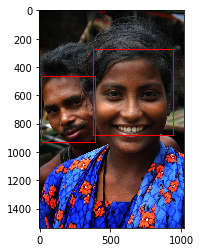

In [65]:
values=valid_flow.next()["data"]
feed_dict = build_feed_dict_end2end(inputs,values)
feed_dict[is_training] = False
predict_roi_bboxes, predict_roi_probs = sess.run([p_roi_bboxes[0], p_roi_probs[0]],
                                                 feed_dict=feed_dict)
img = np.copy(values[0][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height = img.shape[0] - 1
width = img.shape[1] - 1
for i in range(len(predict_roi_probs)):
    if predict_roi_probs[i] > 0.7:
        y1, x1, y2, x2 = predict_roi_bboxes[i] * np.array([height, width, height, width])
        y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 6)
plt.imshow(img)

# RPN EXAMPLES

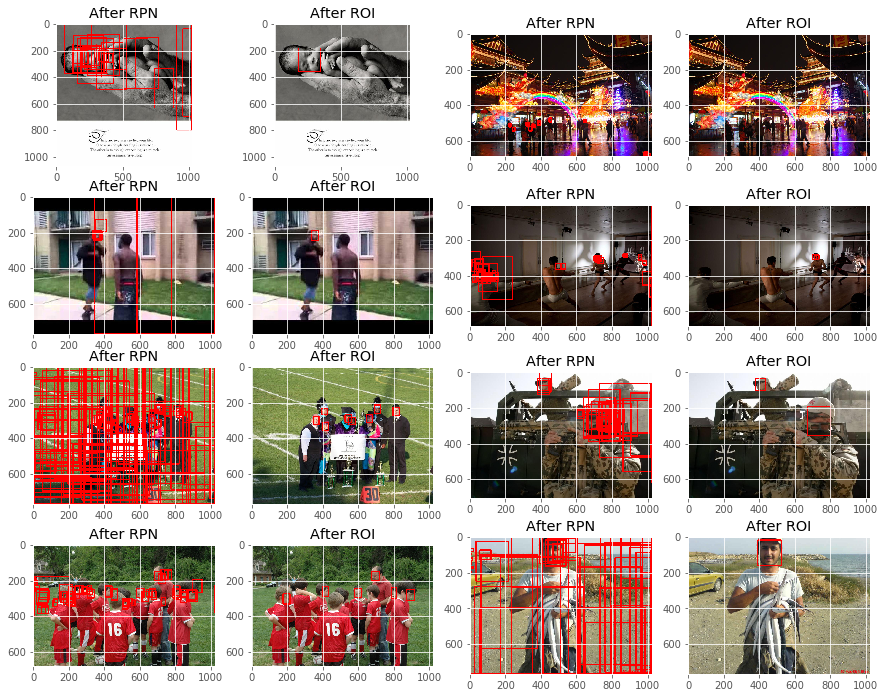

In [77]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 12)
fig, axs = plt.subplots(4, 4)
for row in range(4):
    for col in range(2):
        values=valid_flow.next()["data"]
        feed_dict = build_feed_dict_end2end(inputs,values)
        feed_dict[is_training] = False
        predict_rpn_bboxes, predict_rpn_probs = sess.run([regions_after_nms, logits_after_nms],
                                                         feed_dict=feed_dict)
        predict_roi_bboxes, predict_roi_probs = sess.run([p_roi_bboxes[0], p_roi_probs[0]],
                                                         feed_dict=feed_dict)
        img = np.copy(values[0][0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height = img.shape[0] - 1
        width = img.shape[1] - 1
        for i in range(len(predict_roi_probs)):
            if predict_rpn_probs[i] > 0.8:
                y1, x1, y2, x2 = predict_rpn_bboxes[i] * np.array([height, width, height, width])
                y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 6)
        axs[row][col * 2].imshow(img, aspect=None)
        axs[row][col * 2].set_title('After RPN')
        img = np.copy(values[0][0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height = img.shape[0] - 1
        width = img.shape[1] - 1
        for i in range(len(predict_roi_probs)):
            if predict_roi_probs[i] > 0.7:
                y1, x1, y2, x2 = predict_roi_bboxes[i] * np.array([height, width, height, width])
                y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 6)
        axs[row][col * 2 + 1].imshow(img, aspect=None)    
        axs[row][col * 2 + 1].set_title('After ROI')